In [14]:
import _pickle as cPickle
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tf_filters as tfconv

from PIL import Image
%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'

In [3]:
def read_images(folder):
    fnames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = [np.array(Image.open(os.path.join(folder, f))) for f in fnames]
    return np.array(images)

data = read_images('cifar/')

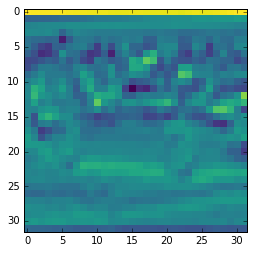

In [10]:
def get_sobel_kernel(ksize):
    if (ksize % 2 == 0) or (ksize < 1):
        raise ValueError("Kernel size must be a positive odd number")
    _base = np.arange(ksize) - ksize//2
    a = np.broadcast_to(_base, (ksize,ksize))
    b = ksize//2 - np.abs(a).T
    s = np.sign(a)
    return a + s*b


def get_gaussian_kernel(ksize = 3, sigma = -1.0):
    ksigma = 0.15*ksize + 0.35 if sigma <= 0 else sigma
    i, j   = np.mgrid[0:ksize,0:ksize] - (ksize-1)//2
    kernel = np.exp(-(i**2 + j**2) / (2*ksigma**2))
    return kernel / kernel.sum()


def get_laplacian_of_gaussian_kernel(ksize = 3, sigma = -1.0):
    ksigma = 0.15*ksize + 0.35 if sigma <= 0 else sigma
    i, j   = np.mgrid[0:ksize,0:ksize] - (ksize-1)//2
    kernel = (i**2 + j**2 - 2*ksigma**2) / (ksigma**4) * np.exp(-(i**2 + j**2) / (2*ksigma**2))
    return kernel - kernel.mean()


def tf_kernel_prep_4d(kernel, n_channels):
    return np.tile(kernel, (n_channels, 1, 1, 1)).swapaxes(0,2).swapaxes(1,3)


def tf_kernel_prep_3d(kernel, n_channels):
    return np.tile(kernel, (n_channels, 1, 1)).swapaxes(0,1).swapaxes(1,2)


def tf_filter2d(batch, kernel, strides=(1,1), padding='SAME'):
    n_ch = batch.shape[3]
    tf_kernel = tf.constant(tf_kernel_prep_4d(kernel, n_ch))
    return tf.nn.depthwise_conv2d(batch, tf_kernel, [1, strides[0], strides[1], 1], padding=padding)
    
    
def tf_deriv(batch, ksize=3, padding='SAME'):
    n_ch = batch.shape[3]
    gx = tf_kernel_prep_3d([[ 0, 0, 0],
                            [-1, 0, 1],
                            [ 0, 0, 0]], n_ch)    
    gy = tf_kernel_prep_3d([[ 0,-1, 0],
                            [ 0, 0, 0],
                            [ 0, 1, 0]], n_ch)   
    kernel = tf.constant(np.stack([gx, gy], axis=-1).astype(batch.dtype), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)
    

def tf_sobel(batch, ksize=3, padding='SAME'):
    n_ch = batch.shape[3]
    gx = tf_kernel_prep_3d(get_sobel_kernel(ksize),   n_ch)
    gy = tf_kernel_prep_3d(get_sobel_kernel(ksize).T, n_ch)
    kernel = tf.constant(np.stack([gx, gy], axis=-1).astype(batch.dtype), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)


def tf_sharr(batch, padding='SAME'):
    n_ch = batch.shape[3]
    gx = tf_kernel_prep_3d([[ -3, 0,  3],
                            [-10, 0, 10],
                            [ -3, 0,  3]], n_ch)
    
    gy = tf_kernel_prep_3d([[-3,-10,-3],
                            [ 0,  0, 0],
                            [ 3, 10, 3]], n_ch)
    
    kernel = tf.constant(np.stack([gx, gy], axis=-1).astype(batch.dtype), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)


def tf_laplacian(batch, padding='SAME'):
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]], dtype=batch.dtype)    
    return tf_filter2d(batch, kernel, padding=padding)


def tf_boxfilter(batch, ksize = 3, padding='SAME'):
    kernel = np.ones((ksize, ksize), dtype=batch.dtype) / ksize**2
    return tf_filter2d(batch, kernel, padding=padding)

der = tf_deriv(data[:10].astype(np.float32))
sob = tf_sobel(data[:10].astype(np.float32), ksize = 3, padding='VALID')
shr = tf_sharr(data[:10].astype(np.float32), 'VALID')
box = tf_boxfilter(data[:10].astype(np.float32), ksize = 3)

init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    sobel = sob.eval()
    sharr = shr.eval()
    deriv = der.eval()
    
    k = 0
    x = deriv[k,:,:,5]    

    plt.imshow(x, interpolation = 'nearest')
    sess.close()